In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import typesetting.main as tm
import numpy as np
import os
from corrLib import readdata
from corr_utils import *
tm.prl('1-column-2-panel')
dirs = data_log_mapping(kw='aug')

# Plans

- <del>finish the calculation for all samples</del>
- <del>draw the kinetics plot (including energy and order) for all samples</del>
- <del>summarize the density fluctuation results (both dynamics and kinetics)</del>
- <del>order parameter calculation seems different from previous version (where shift matrix was used), check the consistency</del>
- 30 n0 data look strange. In correlation length data, they show larger errorbars, and in df data, they show unexpected nonmonotonic trend.
    - indeed, one of the 30 n0 video shows collective motion while the other two don't. This leads to the $l_{vv}$ value larger than expected. However, the low $\alpha$ value has no good explanation yet.
- The low velocity and concentration correlation may result from including the kinetics part of data. It is intuitive that the correlation is weak when bacterial turbulence is now fully developed. Try exclude the initial part!

## 1. Velocity correlation

In [2]:
data = pd.read_excel(io=r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='corrV')
data = data.dropna()
plt.figure(figsize=(3, 2.2))
plt.errorbar(data['conc'], data['avg']*0.33/3, yerr=data['std']*0.33/3, ls='', elinewidth=0.5, marker='o')
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l_{vv}/l_b$')

Text(0, 0.5, '$l_{vv}/l_b$')

In [19]:
lv = np.array(data['avg'])

In [15]:
# summarize data
# sample 10 frames out of the last 1/3 of frames
corr_data_path = r'E:\moreData\08052020\cav_imseq'
num_sample = 20 # number of frames to sample
sample_clA = []
sample_clV = []
sfL = next(os.walk(corr_data_path))[1]
sfL_new = []
for s in sfL:
#     print('sample ' + str(n))
    corr_data_path_num = os.path.join(corr_data_path, s)
    
    # sample 20 frames in the last 1/3 frames
    
    l = len(corrLib.readdata(corr_data_path_num))
    if l > 60:
        samples = np.random.randint((l*2/3)/2, (l-1)/2, num_sample) * 2
        clAL = []
        clVL = []
        for i in samples:
            data_raw = pd.read_csv(os.path.join(corr_data_path_num, '{0:04d}-{1:04d}.csv'.format(i, i+1))) # X Y CA CV
            data_AV = xy_to_r(data_raw).sort_values(by=['R'])     
            clA, fit = corr_length(data_AV.rename(columns={'CA': 'C'}), fitting_range=500)
            clV, fit = corr_length(data_AV.rename(columns={'CV': 'C'}), fitting_range=500)
            clAL.append(clA)
            clVL.append(clV)
        sample_clA.append(np.array(clAL).mean())
        sample_clV.append(np.array(clVL).mean())
        sfL_new.append(int(s))
    else:
        raise ValueError('Too few data to sample from. Need at least 60 .csv files.')
summary = pd.DataFrame({'sample': sfL_new, 'clA': sample_clA, 'clV': sample_clV})
summary.to_csv(os.path.join(corr_data_path, 'summary.csv'), index=False)
### Needs further improvement

In [5]:
corr_data_path = r'E:\moreData\08052020\cav_imseq'
sfL = next(os.walk(corr_data_path))[1]
sfL

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']

In [3]:
dirs

{'120': ['08062020-3', '08062020-4', '08062020-5'],
 '100': ['08062020-0', '08062020-1', '08062020-2'],
 '85': ['08052020-3', '08052020-4', '08052020-5'],
 '80': ['08032020-0', '08032020-1', '08032020-2'],
 '70': ['08042020-0', '08042020-1', '08042020-2'],
 '60': ['08032020-3', '08032020-4', '08032020-5'],
 '50': ['08042020-3', '08042020-4', '08042020-5'],
 '40': ['08032020-6', '08032020-7', '08032020-8'],
 '30': ['08042020-6', '08042020-7', '08042020-8'],
 '20': ['08032020-9', '08032020-10', '08032020-11'],
 '10': ['08042020-9', '08042020-10', '08042020-11'],
 '00': ['08032020-12', '08032020-13', '08032020-14']}

In [36]:
# retrieve data from cav_imseq/summary.csv
folder = r'E:\moreData'
subfolder_name = 'cav_imseq'
data = {'conc': [], 'clA_avg': [], 'clV_avg': [], 'clA_std': [], 'clV_std': []}
for kw in dirs:
    if kw != '00':
        conc = int(kw)
        for n, dn in enumerate(dirs[kw]):
            date, num = dn.split('-')
            summary_dir = os.path.join(folder, date, subfolder_name, 'summary.csv')
            temp = pd.read_csv(summary_dir, index_col='sample').loc[[int(num)]]
            if n == 0:
                conc_data = temp
            else:
                conc_data = conc_data.append(temp)
        data['conc'].append(conc)
        data['clA_avg'].append(conc_data.clA.mean())
        data['clV_avg'].append(conc_data.clV.mean())
        data['clA_std'].append(conc_data.clA.std())
        data['clV_std'].append(conc_data.clV.std())

In [39]:
pd.DataFrame(data)

conc     clA_avg     clV_avg    clA_std    clV_std
0    120  131.100812  111.828270  28.195589  12.638994
1    100  161.152071   96.753156  89.188712   9.837196
2     85  141.072291  100.711927  30.304600  14.873771
3     80   79.118514   82.306710   8.986337   8.614581
4     70  130.699408  113.078446  19.173139   5.336671
5     60  124.650246  116.078907  37.929393  24.759475
6     50  106.842831   96.616186  10.622119  12.428217
7     40  107.955754  101.865676  22.076049  13.505755
8     30  101.501364   81.795533  25.253006  41.343303
9     20   66.145536   63.173435   6.840477   4.618811
10    10   68.019370   41.622898  13.089633   4.026853

## 2. Concentration correlation

In [16]:
data1 = pd.read_excel(io=r'I:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='corrI')
data1 = data1.dropna()
plt.figure(figsize=(3, 2.2))
plt.errorbar(data1['conc'], data1['avg']*0.33/3, yerr=data1['std']*0.33/3, ls='', elinewidth=0.5, marker='o')
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l_{nn}/l_b$')

Text(0, 0.5, '$l_{nn}/l_b$')

In [17]:
ln = np.array(data['avg'])

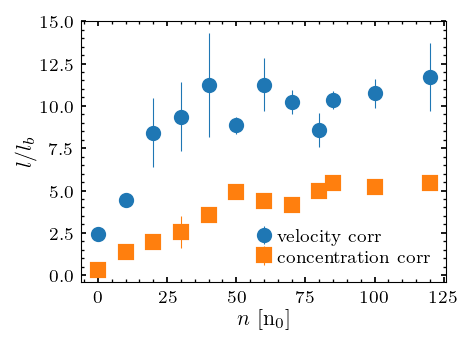

In [13]:
plt.figure(figsize=(3, 2.2))
plt.errorbar(data['conc'], data['avg']*0.33/3, yerr=data['std']*0.33/3, ls='', elinewidth=0.5, marker='o', label='velocity corr')
plt.errorbar(data1['conc'], data1['avg']*0.33/3, yerr=data1['std']*0.33/3, ls='', elinewidth=0.5, marker='s', label='concentration corr')
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l/l_b$')
plt.legend(loc='lower right')

In [22]:
plt.figure(figsize=(3, 2.2))
plt.plot(data['conc'], lv/ln, ls='', marker='o')
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l_{vv}/l_{nn}$')

Text(0, 0.5, '$l_{vv}/l_{nn}$')

## 3. Density fluctuations 

### 3.1 Summarize experiments of a day

#### 3.1.1 Obtain info from one sample

In [15]:
n = 14
date = '08032020'
fps = data_log()[date]['fps'][n]
k_folder = r'E:\moreData\{0}\df2_kinetics\{1:02d}'.format(date, n)
i_folder = r'E:\moreData\{0}\overall_intensity\{1:02d}'.format(date, n)
k_data = pd.read_csv(os.path.join(k_folder, 'kinetics_data.csv'))
i_data = pd.read_csv(os.path.join(i_folder, 'intensity.csv'))
data, fig, ax = plot_kinetics(k_data, i_data, tlim=None, xlim=[0, 100], lb=10, mpp=0.33, seg_length=50, fps=fps)

In [16]:
df = pd.DataFrame().assign(t=data['t0'], alpha=data['alpha'])
# alpha = df['alpha'].loc[df['t']>df['t'].max()*0.8].mean()
alpha = df['alpha'].mean()
print(alpha)

0.1529581979627492


#### 3.1.2 Batch processing

In [5]:
dates = ['08032020', '08042020', '08052020', '08062020']
sampling_range = 1 # range between 0 and 1, above which we sample the alpha values and average

for date in dates:
    date_folder = r'D:\density_fluctuations\{}'.format(date)
    k_master_folder = os.path.join(date_folder, 'df2_kinetics')
    i_master_folder = os.path.join(date_folder, 'overall_intensity')
    sfL = next(os.walk(k_master_folder))[1]
    alpha_list = []
    n_list = []
    for sf in sfL:
        n = int(sf)
        fps = data_log()[date]['fps'][n]
        k_folder = r'D:\density_fluctuations\{0}\df2_kinetics\{1:02d}'.format(date, n)
        i_folder = r'D:\density_fluctuations\{0}\overall_intensity\{1:02d}'.format(date, n)
        k_data = pd.read_csv(os.path.join(k_folder, 'kinetics_data.csv'))
        i_data = pd.read_csv(os.path.join(i_folder, 'intensity.csv'))
        data = plot_kinetics(k_data, i_data, tlim=None, xlim=[1, 10], lb=10, mpp=0.33, seg_length=50, fps=fps, plot=False)
        df = pd.DataFrame().assign(t=data['t0'], alpha=data['alpha'])
        alpha = df['alpha'].loc[df['t']>=df['t'].max()*sampling_range].mean()
        n_list.append(n)
        alpha_list.append(alpha)
    data = pd.DataFrame({'n': n_list, 'alpha': alpha_list})
    data.to_csv(os.path.join(k_master_folder, 'summary.csv'), index=False)

Text(0, 0.5, '$\\alpha$')

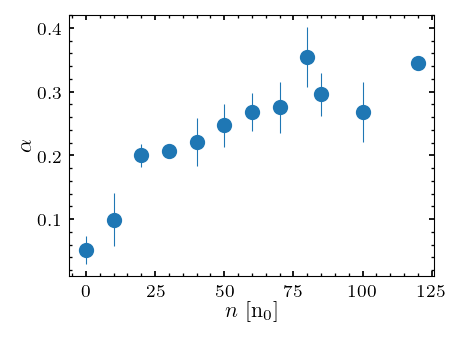

In [17]:
data = pd.read_excel(io=r'I:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='df2')
# data = data.dropna()
plt.figure(figsize=(3, 2.2))
plt.errorbar(data['conc'], data['avg'], yerr=data['std'], ls='', elinewidth=0.5, marker='o')
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$\\alpha$')

In [ ]:
# plot std as a function of box size for various concentrations of bacteria
count = 0
symbol_list = [ 'x', 's', 'P', '*', 'd', 'o', '^']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for kw in dirs:    
    gnf_data_tuple = prepare_multiple_data(dirs[kw])
    collapsed = collapse_data(gnf_data_tuple, 10, xlim=[1, 100], sparse=3)
    ax.plot(collapsed.index, collapsed.avg, mec=bestcolor(count), 
            label=kw, lw=0, marker=symbol_list[count], markersize=4, mfc=(0,0,0,0), mew=1)
    ax.errorbar(collapsed.index, collapsed.avg, yerr=collapsed['std'], 
                 marker=symbol_list[count], capsize=1, lw=0, elinewidth=0.5, mec=bestcolor(count), 
                markersize=4, mfc=(0,0,0,0), mew=1, ecolor=bestcolor(count))
    count += 1
ax.loglog()
ax.set_ylim([0.9, 11])
# ax.yaxis.set_major_formatter(ScalarFormatter())

ax.legend(ncol=2)
ax.set_xlabel('$l^2/l_b^2$')
ax.set_ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([3, 15])
y = x**0.5 *1.2
ax.plot(x, y, color='black', lw=0.5, ls='--')
ax.text(0.6*x[0]+0.2*x[1], 0.5*y[0]+0.5*y[1], '0.5', fontsize=6)
# plt.savefig(r'E:\Github\Personal-Images\07142020\GNF-clean.png', fmt='png')

## 4. Density fluctuation kinetics

|concentration|sample 1|sample 2|sample 3|
|:---------:|:---------:|:---------:|:---------:|
|85|![](temp_data\kinetics_eo\85-1.png)|![](temp_data\kinetics_eo\85-2.png)|![](temp_data\kinetics_eo\85-3.png)|
|80|![](temp_data\kinetics_eo\80-1.png)|![](temp_data\kinetics_eo\80-2.png)|![](temp_data\kinetics_eo\80-3.png)|
|70|![](temp_data\kinetics_eo\70-1.png)|![](temp_data\kinetics_eo\70-2.png)|![](temp_data\kinetics_eo\70-3.png)|
|60|![](temp_data\kinetics_eo\60-1.png)|![](temp_data\kinetics_eo\60-2.png)|![](temp_data\kinetics_eo\60-3.png)|
|50|![](temp_data\kinetics_eo\50-1.png)|![](temp_data\kinetics_eo\50-2.png)|![](temp_data\kinetics_eo\50-3.png)|
|40|![](temp_data\kinetics_eo\40-1.png)|![](temp_data\kinetics_eo\40-2.png)|![](temp_data\kinetics_eo\40-3.png)|
|30|![](temp_data\kinetics_eo\30-1.png)|![](temp_data\kinetics_eo\30-2.png)|![](temp_data\kinetics_eo\30-3.png)|
|20|![](temp_data\kinetics_eo\20-1.png)|![](temp_data\kinetics_eo\20-2.png)|![](temp_data\kinetics_eo\20-3.png)|
|10|![](temp_data\kinetics_eo\10-1.png)|![](temp_data\kinetics_eo\10-2.png)|![](temp_data\kinetics_eo\10-3.png)|
|0|![](temp_data\kinetics_eo\0-1.png)|![](temp_data\kinetics_eo\0-2.png)|![](temp_data\kinetics_eo\0-3.png)|

## 5. Correlation between concentration and velocity

### 5.1 Local concentration fluctuations and velocity

We have found that local concentration fluctuation, which is defined as the standard deviation of concentrations at certain place over a short time, shows high correlation with the magnitude of the product between velocity and concentration gradient. This product can be interpreted as the concentration change caused by advection flows. 

In [21]:
data = pd.read_excel(io=r'I:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='flow_conc_corr')

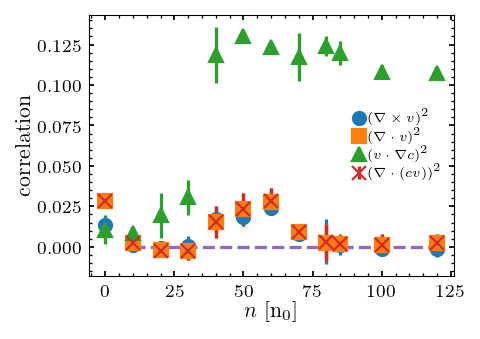

In [24]:
plt.figure(figsize=(3, 2.2))
markers = {'vorticity': 'o', 'divergence': 's', 'convection': '^', 'divcn': 'x'}
labels = {}
labels['vorticity'] = r'$(\nabla\times v)^2$'
labels['divergence'] = r'$(\nabla\cdot v)^2$'
labels['convection'] = r'$(v\cdot\nabla c)^2$'
labels['divcn'] = r'$(\nabla \cdot (cv))^2$'

for kw in markers:
    plt.errorbar(data['conc'], data[kw], yerr=data[kw+'_err'], label=labels[kw],
                ls='', marker=markers[kw])
    

plt.legend(loc='right', fontsize=6)
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('correlation')
plt.plot([10, 120], [0, 0], ls='--')

### 5.2 Why do I only consider the correlation between concentration fluctuation and advection magnitude?

Concentration fluctuation is defined by standard deviation, and is used for quantifying the magnitude of concentration change at a place within certain amount of time. So, it is always a positive value and has no direction. In contrast, fluid flows always have directions, including the advection: when flow velocity and concentration gradient are in the same direction(\*), the advection is positive, and particles are advected uphill to a higher concentration region; when flow velocity and concentration gradient are in opposite directions, the advection is negative, and particles are advected downhill to a lower concentration region. 

Both positive and negative advections cause local concentrations to change. We have already seen in the data, that local concentration fluctuation correlates with the magnitude of local advection very well. What if we consider not only the magnitude of the advection, but also the direction? The picture below shows the two scenario - considering or not considering direction of advcetion - and their corresponding correlation. The first row shows the local concentration fluctuation field, advection magnitude and their correlation. The second row shows the local concentration correlation, advection with direction and their correlation. Clearly, advection magnitude shows better correlation. Directly eye inspection also suggests a good consistency between local concentration fluctuation and advection magnitude.

\*: the direction of concentration gradient is defined as the ascending direction

<img src="temp_data\why_magnitude.png" width="500">

### 5.3 Why do bacteria generate such flows?

Though our analysis reveals that the advection drives the concentration fluctuations, we still have a question: why do bacteria generate such flows, which goes uphill in concentration, in the same direction with concentration gradient? In other words, given a concentration field, can we predict the flow field?

We are seeking the evolution rules of concentration. Now, it gets clear that concentration field at one moment gives rise to the concentration field in the next moment by generating flows. A changed concentration field leads to a changed flow field, which, changes the concentration field for sure, but in a different way. 

## 6. Dimensionality effect

Probe dimensionality effect by gradually changing the chamber thickness (200, 140, 100, <del>20</del>)

In [10]:
data = pd.read_excel(r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='dimensionality').dropna()

Text(0, 0.5, '$\\alpha$')

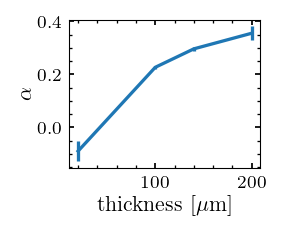

In [15]:
plt.errorbar(data['thickness'], data['alpha_avg'], yerr=data['alpha_std'])
plt.xlabel('thickness [$\mu$m]')
plt.ylabel('$\\alpha$')

Text(0, 0.5, 'energy [px$^2$/s$^2$]')

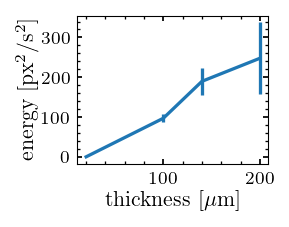

In [17]:
plt.errorbar(data['thickness'], data['energy_avg'], yerr=data['energy_std'])
plt.xlabel('thickness [$\mu$m]')
plt.ylabel('energy [px$^2$/s$^2$]')

**<font color='red'>Question:</font>** when reducing chamber thickness, the density fluctuation scaling exponent does decrease. However, the flow energy decreases at the mean time. This observation has posed a question: does thickness influence the overall motility of bacteria, or just suppress interaction between bacteria by approaching two dimensional settings? 

## 7. Debug dxd code

In [20]:
div = pd.read_csv('temp_data\dxd_bug\div.csv')
dc_adv = pd.read_csv('temp_data\dxd_bug\dc_adv.csv')

In [27]:
col = len(div.x.drop_duplicates())
row = len(div.y.drop_duplicates())

In [29]:
div.columns

Index(['x', 'y', 'divcn', 'divcv', 'divv'], dtype='object')

In [30]:
dc_adv.columns

Index(['x', 'y', 'dcx', 'dcy', 'dc', 'adv', 'vdc'], dtype='object')

In [39]:
mat1 = np.array(div.divv).reshape(row, col)
mat2 = np.array(dc_adv.adv).reshape(row, col)

In [40]:
mat1 = (mat1 - mat1.mean()) / mat1.std()
mat2 = (mat2 - mat2.mean()) / mat2.std()

In [46]:
(mat1 * mat2).mean()

0.038087017838403035

In [31]:
np.random.seed(1)
a = np.random.randn(2, 2)
b = np.random.randn(2, 2)
from scipy import signal
signal.correlate2d(a, b, 'same')

array([[ 2.70889276, -2.40154694],
       [ 2.01239494, -0.92855523]])

**Result:** the mismatch in coordinates is not the cause of the empty dxd data.

In [51]:
dcadv_folder = r'E:\moreData\08052020\dc_adv\00\dt=60'
l = readdata(dcadv_folder)

In [54]:
l.loc[l.index>len(l)*0.9]

Name                                                Dir
1594  3188-3248  E:\moreData\08052020\dc_adv\00\dt=60\3188-3248...
1595  3190-3250  E:\moreData\08052020\dc_adv\00\dt=60\3190-3250...
1596  3192-3252  E:\moreData\08052020\dc_adv\00\dt=60\3192-3252...
1597  3194-3254  E:\moreData\08052020\dc_adv\00\dt=60\3194-3254...
1598  3196-3256  E:\moreData\08052020\dc_adv\00\dt=60\3196-3256...
...         ...                                                ...
1765  3530-3590  E:\moreData\08052020\dc_adv\00\dt=60\3530-3590...
1766  3532-3592  E:\moreData\08052020\dc_adv\00\dt=60\3532-3592...
1767  3534-3594  E:\moreData\08052020\dc_adv\00\dt=60\3534-3594...
1768  3536-3596  E:\moreData\08052020\dc_adv\00\dt=60\3536-3596...
1769  3538-3598  E:\moreData\08052020\dc_adv\00\dt=60\3538-3598...

[176 rows x 2 columns]